In [1]:
#%matplotlib notebook
import sys
import os
#messi
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

import s2p
import pickle 

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Read SkySat images and RPCs

In [2]:
import glob

rpcs_from_images = True

# load images from folder and rpcs from TXT
exp_name = 'skysat_L1A/dona_juana1_fake'
input_dir = os.path.join('ba_experiments/',exp_name)

# read tiff images 
myimages = np.sort(glob.glob(input_dir+'/frames/*.tif'))
myimages = myimages[:20]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
myimg = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    myimg.append(utils.simple_equalization_8bit(tmp))
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(myimg)

# load RPC coefficients
if not rpcs_from_images:
    #myrpcs2 = [rpc_model.RPCModel('../IS18/'+os.path.splitext(im)[0]+'_rpc.txt') for im in myimages]
    myrpcs2 = [s2p.rpc_model.RPCModel(os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
else:
    myrpcs2 = [s2p.rpc_utils.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

#for rpc in myrpcs2:
#    rpc.alt_scale = 1000

Found 3 images
Number of images to be used: 3
Finished loading RPC coefficients


#### Experiment: project 3D grid to the image

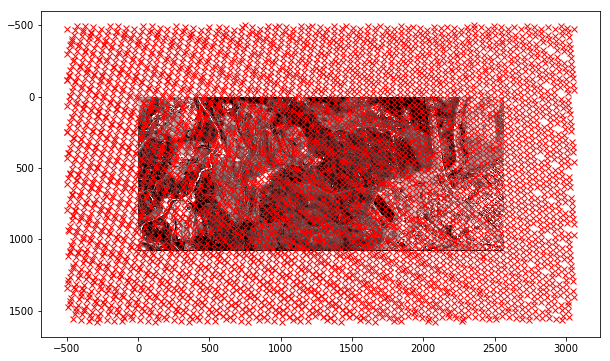

In [3]:
import json

im_idx = 2

h, w = mycrops[im_idx]['crop'].shape

with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
        input_P = np.array(json.load(f)['P_projective'])
    
# Calculate z_mean as average altitude of image's footprint 
footprint = utils.get_image_longlat_polygon(myimages[im_idx])
lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
z_mean = srtm4.srtm4(lon, lat)

    
ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
m1, m2, grid_size = 5*1e+3, 500, (40, 40, 40)
x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
samples = np.zeros((x_grid.size, 3), dtype = np.float32)
samples[:, 0] = x_grid.ravel()
samples[:, 1] = y_grid.ravel()
samples[:, 2] = z_grid.ravel()

p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
p = (p[:2,:]/p[-1,:]).T
idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
proj_pts, samples = p[idx_to_preserve], samples[idx_to_preserve]

fig = plt.figure(figsize=(20,6))
plt.imshow((mycrops[im_idx]['crop']), cmap="gray")
for k in range(proj_pts.shape[0]):
    plt.plot(*proj_pts[k][::-1], 'rx') 
plt.show()

### Fit RPCs from projection matrices

In [4]:
import json
import rpc_fit
import copy


if not os.path.isdir(input_dir+'/rpc_adj'):
    os.mkdir(input_dir+'/rpc_adj')

# rpc fitting starts here
verbose = True
for im_idx in range(n_cam):

    rpc_init = copy.copy(myrpcs2[im_idx])
    h, w = mycrops[im_idx]['crop'].shape
    
    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
        input_P = np.array(json.load(f)['P_projective'])
    
    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 500, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    # warning: this is slow...
    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts, samples = p[idx_to_preserve], samples[idx_to_preserve]

    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    rpc_calib.write_to_file(input_dir+'/rpc_adj/'+rpc_calib_fn)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

    myrpcs2[im_idx] = copy.copy(rpc_calib)

image 0, RMSE calibrated RPC = 0.0003612738880475901
image 1, RMSE calibrated RPC = 0.0002191844696359532
image 2, RMSE calibrated RPC = 0.0002004392400325164


### Approximate RPCs as projection matrices

In [5]:
# approximate rpcs as a as projective matrices

cam_model = 'Perspective'
P_crop = []
for rpc2, crop, iter_cont in zip(myrpcs2, mycrops, np.arange(len(mycrops))):
    x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
    P_img = s2p.rpc_utils.approx_rpc_as_proj_matrix(rpc2, [x,x+w,10], [y,y+h,10], \
                                                [rpc2.alt_offset - 100, rpc2.alt_offset + 100, 10])
    P_crop.append(P_img/P_img[2,3])
    print('\rCamera {} / {} done'.format(iter_cont+1, len(mycrops)), end = '\r')

print('\nRPCs successfully approximated as projection matrices')

Camera 3 / 3 done
RPCs successfully approximated as projection matrices


### Read projection matrices

In [6]:
import json
import rpc_fit
import copy


# approximate rpcs as a as projective matrices

cam_model = 'Perspective'
P_crop = []
for iter_cont in np.arange(len(mycrops)):
    
    with open(os.path.splitext(myimages[iter_cont])[0]+'_pinhole.json', 'r') as f:
        P_img = np.array(json.load(f)['P_projective'])
        
    P_crop.append(P_img/P_img[2,3])
    print('\rCamera {} / {} done'.format(iter_cont+1, len(mycrops)), end = '\r')

print('\nProjection matrices read')

Camera 3 / 3 done
Projection matrices read


In [7]:
# select which feature track construction pipeline you want to use

feature_tracks_1 = False
feature_tracks_2 = True
feature_tracks_3 = False

### Feature Track Detection 1.0

Improvements w.r.t version 0.0: hashing and intersection to build the tracks quickly as the new pairwise matches are found (sequential process).

In [8]:
if feature_tracks_1:

    # $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
    # otherwise sift might not work
    import cv2
    from multiprocessing import Pool

    #FEATURE TRACKS REPRESENTATION
    #feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
    #r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

    input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]   
    input_P = P_crop

    print('Running feature detection...\n')
    start = timeit.default_timer()
    last_stop = start

    # (1) detect SIFT keypoints in all images
    reduce_kp, max_kp_per_im = False, 7000
    n_img = len(input_seq)

    kp_cont = 0
    features = []
    for idx in range(n_img):
        kp, des = ba_utils.find_SIFT_kp(input_seq[idx])
        if kp.shape[0] > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(kp.shape[0])
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des, 'id': np.arange(kp_cont, kp_cont + len(kp)).tolist() })
        print('Found', kp.shape[0], 'keypoints in image', idx)
        kp_cont += kp.shape[0]
        #im_kp=cv2.drawKeypoints(input_seq[idx],kp,outImage=np.array([]))
        #vistools.display_image(im_kp) 

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nComputing pairs to be matched...\n')

    #(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
    pairs_to_match, matching_args = [], []
    for i in range(n_img):
        for j in range(i+1,n_img):
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(input_P[i])
            _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(input_P[j])

            baseline_thr = 150000 # esto deberian ser un poco más de la distancia recorrida en medio segundo (en m ?)
                                  # no me cuadra mucho con la supuesta speed de skysat de 7 km/s (~3500 m en medio s)

            if np.linalg.norm(optical_center2 - optical_center1) > baseline_thr :
                pairs_to_match.append([i,j])
                kp_i, des_i, kp_i_id = features[i]['kp'], features[i]['des'], np.array(features[i]['id'])
                kp_j, des_j, kp_j_id = features[j]['kp'], features[j]['des'], np.array(features[j]['id'])
                matching_args.append((kp_i, kp_j, des_i, des_j))

    print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nMatching...\n')

    # (3) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for [i,j] in pairs_to_match:
        kp_i, des_i = features[i]['kp'], features[i]['des']
        kp_j, des_j = features[j]['kp'], features[j]['des']
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all, _, _ = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
        n_matches = 0 if pts_i is None else pts_i.shape[0]
        print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

        if pts_i is not None:
            pts_i_tuples = [tuple(pair) for pair in pts_i.tolist()]
            pts_i_dict = {pair:i for i, pair in enumerate(pts_i_tuples)}

            pts_i_track = [tuple(pair) for pair in feature_tracks[:,:,i].tolist()]
            pts_i_track_dict = {pair:i for i, pair in enumerate(pts_i_track)}

            intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
            # attention: the meaning/interst of 'intersect' is not trivial
            # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
            # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
            if intersect.shape[0] > 0:
                idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
                # extend existing tracks by adding the coords of observation X in image j from pts_j
                feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
                r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1

            # list of points in 'pts_i' that do not correspond to any previous feature track
            new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
            if len(new_pts_from_i) > 0:
                new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
                new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
                new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
                new_r = np.zeros((len(new_pts_from_i),n_cam))
                new_r[:,i], new_r[:,j] = 1, 1
                feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))

    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nBuilding correspondence matrix C...\n')

    C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

    stop = timeit.default_timer()
    print('\n\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    hours, rem = divmod(last_stop - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))
    
    pickle_out = open(input_dir+'/features.pickle','wb')
    pickle.dump(C, pickle_out)
    pickle_out.close()
    print('\nCorrespondence matrix saved!')

### Feature Track Detection 2.0

Improvements w.r.t version 1.0: uses the union-find algorithm (i.e. the construction of feature tracks is not sequential anymore).

In [9]:
if feature_tracks_2:

    import timeit
    import cv2
    from multiprocessing import Pool

    input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]    
    input_P = P_crop

    print('Running feature detection...\n')
    start = timeit.default_timer()
    last_stop = start

    # (1) detect SIFT keypoints in all images
    n_img = len(input_seq)

    reduce_kp, max_kp_per_im = False, 7000
    kp_cont = 0
    features, all_keypoints, all_vertices = [], [], []
    for idx in range(n_img):
        kp, des = ba_utils.find_SIFT_kp(input_seq[idx])
        if kp.shape[0] > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(kp.shape[0])
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        kp_id = np.arange(kp_cont, kp_cont + kp.shape[0]).tolist()
        features.append({ 'kp': kp, 'des': des, 'id': kp_id })
        all_keypoints.extend(kp.tolist())
        tmp = np.vstack((np.ones(kp.shape[0]).astype(int)*idx, kp_id)).T
        all_vertices.extend( tmp.tolist() )
        print('Found', kp.shape[0], 'keypoints in image', idx)
        kp_cont += len(kp)
        #im_kp=cv2.drawKeypoints(input_seq[idx],kp,outImage=np.array([]))
        #vistools.display_image(im_kp) 

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    import rpcm
    from shapely.geometry import Polygon, mapping, shape
    
    print('\nComputing pairs to be matched...\n')

    #(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
    pairs_to_match, matching_args = [], []
    for i in range(n_img):
        for j in range(i+1,n_img):
            
            #pairs_to_match.append([i,j])
            
            # check there is enough overlap between the images (at least 10% w.r.t image 1)
            footprint_i, footprint_j = rpcm.image_footprint(myimages[i]), rpcm.image_footprint(myimages[j])
            polygon_i, polygon_j = shape(footprint_i), shape(footprint_j)
            intersection_polygon = polygon_i.intersection(polygon_j)        
            overlap_ok = intersection_polygon.area/polygon_i.area >= 0.05

            # check if the baseline between both cameras is large enough
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
            _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
            baseline_ok = np.linalg.norm(optical_center2 - optical_center1) > 150000

            baseline_ok = True
            
            if overlap_ok and baseline_ok:
                pairs_to_match.append([i,j])

    print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nMatching...\n')

    # (3) match
    all_pairwise_matches = []
    for idx, [i,j] in enumerate(pairs_to_match):
        kp_i, des_i, kp_i_id = features[i]['kp'], features[i]['des'], np.array(features[i]['id'])
        kp_j, des_j, kp_j_id = features[j]['kp'], features[j]['des'], np.array(features[j]['id'])
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all, indices_m_kp_i, indices_m_kp_j = ba_utils.match_pair(kp_i, kp_j, des_i, des_j)

        n_matches = 0 if indices_m_kp_i is None else len(indices_m_kp_i)
        print('Pair ({},{}) -> {} matches'.format(i,j,n_matches))

        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

        if pts_i is not None:
            matches_i_j = np.vstack((kp_i_id[indices_m_kp_i], kp_j_id[indices_m_kp_j])).T
            all_pairwise_matches.extend(matches_i_j.tolist())

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nRunning union-find...')

    def find(parents, feature_id):
        p = parents[feature_id]
        return feature_id if not p else find(parents, p)

    def union(parents, feature_i_idx, feature_j_idx):
        p_1, p_2 = find(parents, feature_i_idx), find(parents, feature_j_idx)
        if p_1 != p_2: 
            parents[p_1] = p_2

    parents = [None]*(len(all_vertices))
    for feature_i_idx, feature_j_idx in all_pairwise_matches:
        #fi, fj = vertex_i_idx, vertex_j_idx
        union(parents, feature_i_idx, feature_j_idx)

    # parents without None
    parents = [find(parents, feature_id) for feature_id, v in enumerate(parents)]

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nBuilding correspondence matrix C...\n')

    # parents = track_id
    _, parents_indices, parents_counts = np.unique(parents, return_inverse=True, return_counts=True)
    n_tracks = np.sum(1*(parents_counts>1))
    track_parents = np.array(parents)[parents_counts[parents_indices] > 1]
    _, track_idx_from_parent, _ = np.unique(track_parents, return_inverse=True, return_counts=True)

    # t_idx, parent_id
    track_indices = np.zeros(len(parents))
    track_indices[:] = np.nan
    track_indices[parents_counts[parents_indices] > 1] = track_idx_from_parent

    C = np.zeros((2*n_cam, n_tracks))
    C[:] = np.nan
    for (feature_i_id, feature_j_id) in all_pairwise_matches:
        t_idx, t_idx2 = int(track_indices[feature_i_id]), int(track_indices[feature_j_id])
        im_id_i, im_id_j = all_vertices[feature_i_id][0], all_vertices[feature_j_id][0]
        C[(2*im_id_i):(2*im_id_i+2), t_idx] = np.array(all_keypoints[feature_i_id])
        C[(2*im_id_j):(2*im_id_j+2), t_idx] = np.array(all_keypoints[feature_j_id])

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    hours, rem = divmod(last_stop - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))
    
    pickle_out = open(input_dir+'/features.pickle','wb')
    pickle.dump(C, pickle_out)
    pickle_out.close()
    print('\nCorrespondence matrix saved!')

Running feature detection...

Found 35729 keypoints in image 0
Found 34073 keypoints in image 1
Found 35256 keypoints in image 2

...done in 3.177176021039486 seconds

Computing pairs to be matched...

3 / 3 pairs to be matched

...done in 1.60713492333889 seconds

Matching...

Pair (0,1) -> 1348 matches
Pair (0,2) -> 242 matches
Pair (1,2) -> 1202 matches

...done in 21.921112343668938 seconds

Running union-find...

...done in 0.01746322587132454 seconds

Building correspondence matrix C...


...done in 0.048573896288871765 seconds

Total time: 00:00:26.77

Correspondence matrix saved!


### Feature Track Detection 3.0

Uses union-find + parallelized s2p matching + intersection over image footprints to futher discard useless matching pairs.

In [10]:
if feature_tracks_3:

    from numpy.core.defchararray import add as add_str

    def create_kp_id(pt_coords, im_idx):
        pt = np.around(pt_coords[:,:2],4)
        pt_str = add_str(add_str('(',add_str(pt[:,0].astype('str'),',')),add_str(pt[:,1].astype('str'),')'))
        kp_id = add_str(pt_str,add_str('-',str(im_idx)))
        return kp_id

    import timeit
    from multiprocessing import Pool

    thresh_dog = 0.0133
    nb_octaves = 8
    nb_scales = 3
    offset = None

    n_img = len(mycrops)
    sift_args = [(mycrops[f]['crop'], thresh_dog, nb_octaves, nb_scales, offset) for f in range(n_img)]    

    print('Running feature detection...\n')
    start = timeit.default_timer()
    last_stop = start

    # (1) detect SIFT keypoints in all images

    with Pool() as p:
        features_output = p.starmap(s2p.sift.keypoints_from_nparray, sift_args)

    kp_cont = 0
    reduce_kp, max_kp_per_im = False, 7000
    features, kp_id_to_kp_idx, all_vertices, all_keypoints = [], {}, [], []
    for idx in range(n_img):
        kp = features_output[idx]
        if kp.shape[0] > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(kp.shape[0])
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            kp = kp[new_idx, :]
        all_keypoints.extend(kp[:,:2].tolist())
        kp_id = create_kp_id(kp[:,:2], idx)
        kp_idx = np.arange(kp_cont, kp_cont + kp.shape[0]).tolist()
        kp_id_to_kp_idx.update(dict(zip(kp_id, kp_idx)))
        tmp = np.vstack((np.ones(kp.shape[0]).astype(int)*idx, kp_idx)).T
        all_vertices.extend( tmp.tolist() )
        print('Found', kp.shape[0], 'keypoints in image', idx)
        kp_cont += len(kp)

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop


    import rpcm
    from shapely.geometry import Polygon, mapping, shape

    print('Computing pairs to be matched...\n')

    # set matching parameters
    method = 'relative'
    sift_thr = 0.6
    epipolar_thr = 10
    model = 'fundamental'
    ransac_max_err = 0.3

    #(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
    pairs_to_match, matching_args = [], []
    for i in range(n_img):
        for j in range(i+1,n_img):

            #pairs_to_match.append([i,j])
            
            # check there is enough overlap between the images (at least 10% w.r.t image 1)
            footprint_i, footprint_j = rpcm.image_footprint(myimages[i]), rpcm.image_footprint(myimages[j])
            polygon_i, polygon_j = shape(footprint_i), shape(footprint_j)
            intersection_polygon = polygon_i.intersection(polygon_j)        
            overlap_ok = intersection_polygon.area/polygon_i.area >= 0.05

            # check if the baseline between both cameras is large enough
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
            _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
            baseline_ok = np.linalg.norm(optical_center2 - optical_center1) > 150000

            baseline_ok = True
            
            if overlap_ok and baseline_ok:
                pairs_to_match.append([i,j])

                h, w = mycrops[i]['crop'].shape
                
                rpc_matches = s2p.rpc_utils.matches_from_rpc(myrpcs2[i], myrpcs2[j], 0, 0, w, h, 5)
                
                Fij = s2p.estimation.affine_fundamental_matrix(rpc_matches)

                matching_args.append((features_output[i], features_output[j], 
                                      method, sift_thr, Fij, epipolar_thr, model, ransac_max_err))

    print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    # (3) match

    print('\nMatching...\n')

    with Pool() as p:
        matching_output = p.starmap(s2p.sift.keypoints_match, matching_args)

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    all_pairwise_matches = []
    for pair_idx, [im_i_idx, im_j_idx] in enumerate(pairs_to_match):
        n_matches = matching_output[pair_idx].shape[0]
        print('Pair ({},{}) -> {} matches'.format(im_i_idx,im_j_idx,n_matches))
        if  n_matches > 0:
            pt_i, pt_j = matching_output[pair_idx][:,:2], matching_output[pair_idx][:,2:]
            kp_i_id, kp_j_id = create_kp_id(pt_i, im_i_idx), create_kp_id(pt_j, im_j_idx)

            kp_i_idx = [kp_id_to_kp_idx[k] for k in kp_i_id]
            kp_j_idx = [kp_id_to_kp_idx[k] for k in kp_j_id]

            matches_i_j = np.vstack((kp_i_idx, kp_j_idx)).T
            all_pairwise_matches.extend(matches_i_j.tolist())

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nRunning union-find...')

    def find(parents, feature_id):
        p = parents[feature_id]
        return feature_id if not p else find(parents, p)

    def union(parents, feature_i_idx, feature_j_idx):
        p_1, p_2 = find(parents, feature_i_idx), find(parents, feature_j_idx)
        if p_1 != p_2: 
            parents[p_1] = p_2

    parents = [None]*(len(all_vertices))
    for feature_i_idx, feature_j_idx in all_pairwise_matches:
        #fi, fj = vertex_i_idx, vertex_j_idx
        union(parents, feature_i_idx, feature_j_idx)

    # set properly parents that are none
    parents = [find(parents, feature_id) for feature_id, v in enumerate(parents)]

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nBuilding correspondence matrix C...\n')

    # parents = track_id
    _, parents_indices, parents_counts = np.unique(parents, return_inverse=True, return_counts=True)
    n_tracks = np.sum(1*(parents_counts>1))
    track_parents = np.array(parents)[parents_counts[parents_indices] > 1]
    _, track_idx_from_parent, _ = np.unique(track_parents, return_inverse=True, return_counts=True)

    # t_idx, parent_id
    track_indices = np.zeros(len(parents))
    track_indices[:] = np.nan
    track_indices[parents_counts[parents_indices] > 1] = track_idx_from_parent

    C = np.zeros((2*n_cam, n_tracks))
    C[:] = np.nan
    keypoints_ids = [*kp_id_to_kp_idx]
    for (feature_i_id, feature_j_id) in all_pairwise_matches:
        t_idx, t_idx2 = int(track_indices[feature_i_id]), int(track_indices[feature_j_id])
        im_id_i, im_id_j = all_vertices[feature_i_id][0], all_vertices[feature_j_id][0]
        C[(2*im_id_i):(2*im_id_i+2), t_idx] = np.array(all_keypoints[feature_i_id])
        C[(2*im_id_j):(2*im_id_j+2), t_idx] = np.array(all_keypoints[feature_j_id])

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    hours, rem = divmod(last_stop - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))
    
    pickle_out = open(input_dir+'/features.pickle','wb')
    pickle.dump(C, pickle_out)
    pickle_out.close()
    print('\nCorrespondence matrix saved!')

In [11]:
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

In [12]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()

### Visualize a feature track before Bundle Adjustment

Initializing 3D points...
...done!

 ----> Real 2D loc in im 1  (sol) =  [523.79949951 282.08950806]
 ----> Proj 2D loc in im 1  before BA =  [523.43140852 282.02311749]
              Reprojection error beofre BA: 0.43448155600123073
 ----> Real 2D loc in im 2  (sol) =  [623.6854248 360.2805481]
 ----> Proj 2D loc in im 2  before BA =  [623.9291612 360.330039 ]
              Reprojection error beofre BA: 0.2932273040869404


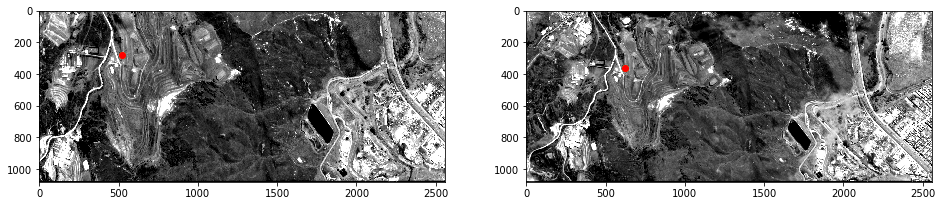

In [13]:
print('Initializing 3D points...')

pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('...done!\n')

p_ind = np.random.choice(np.arange(0,C.shape[1]))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    #proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    #p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]  # col, row
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    #print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    #print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'], cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    #f[cont].plot(*p_2d_proj_ba, "go")

Load feature tracks:

In [14]:
pickle_in = open(input_dir+'/features.pickle','rb')
C = pickle.load(pickle_in)
print('Correspondence matrix loaded!')

Correspondence matrix loaded!


Remove incomplete tracks if wanted:

In [15]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()

# select a random subset of 1000 obs
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

#C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

#print('Only complete feature tracks were preserved: {} in total'. format(C.shape[1]))

### Initialize 3D points for Bundle Adjustment

In [16]:
print('Initializing 3D points...')

pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('...done!\n')

print(pts_3d)

Initializing 3D points...
...done!

[[ 1737980.97054907 -6119111.7713916    500096.93980317]
 [ 1737984.65827704 -6119130.84179808   499962.88004793]
 [ 1737996.96162565 -6119177.97359069   499816.74867119]
 ...
 [ 1740172.89370863 -6118319.45392305   500248.3191753 ]
 [ 1740188.58399839 -6118352.92635399   500047.31889712]
 [ 1740202.63046933 -6118395.67934081   499623.66366803]]


### Define Bundle Adjustment parameters

In [17]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

print('Defining BA input parameters...')

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('...done!\n')

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

Defining BA input parameters...
...done!

pts_2d.shape:(5213, 2)  pts_ind.shape:(5213,)  cam_ind.shape:(5213,)
pts_3d.shape:(2503, 3)  cam_params.shape:(3, 11) cam_params_opt.shape:(3, 3)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run Bundle Adjustment (soft L1 loss)

Shape of matrix A: 10426x7518
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9819e+03                                    4.59e+09    


/home/rogermm14/.local/lib/python3.6/site-packages/scipy/sparse/lil.py:510: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


       1              8         3.6298e+03      1.35e+03       3.06e+01       3.67e+09    
       2             10         3.3294e+03      3.00e+02       3.43e+01       3.41e+09    
       3             11         2.9614e+03      3.68e+02       1.63e+01       2.74e+09    
       4             12         2.4529e+03      5.08e+02       1.29e+01       2.08e+09    
       5             13         1.6688e+03      7.84e+02       2.65e+01       1.72e+09    
       6             14         1.3032e+03      3.66e+02       5.64e+01       8.03e+08    
       7             15         1.1113e+03      1.92e+02       5.66e+01       7.88e+08    
       8             16         9.6650e+02      1.45e+02       7.27e+01       5.34e+08    
       9             17         7.5697e+02      2.10e+02       1.37e+02       2.74e+08    
      10             18         3.6706e+02      3.90e+02       2.75e+02       1.44e+08    
      11             20         1.8696e+02      1.80e+02       1.37e+02       1.22e+08    

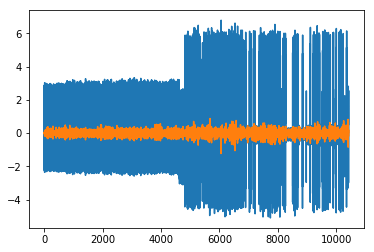

In [18]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

### Check reprojection error before and after Bundle Adjustment

Error before BA (mean / median): 2.47 / 2.66
Error after  BA (mean / median): 0.16 / 0.13


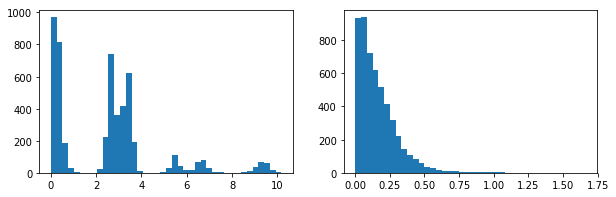

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40);
f[1].hist(ba_e, bins=40); 

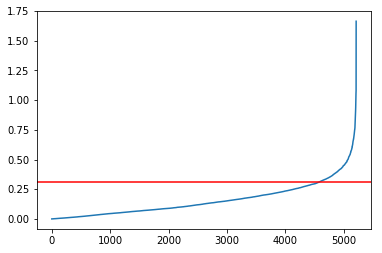

In [ ]:
def get_elbow_value(init_e):

    sort_indices = np.argsort(init_e)
    
    values = np.sort(init_e).tolist()
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T

    # get the first point
    firstPoint = allCoord[0]
    # get vector between first and last point - this is the line
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))

    # find the distance from each point to the line:
    # vector between all points and first point
    vecFromFirst = allCoord - firstPoint

    scalarProduct = np.sum(vecFromFirst * np.tile(lineVecNorm, (nPoints, 1)), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    # distance to line is the norm of vecToLine
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    # knee/elbow is the point with max distance value
    elbow_value = values[np.argmax(distToLine)]

    elbow_value = np.percentile(init_e[init_e < elbow_value], 95)
    
    return elbow_value

error = ba_e
plt.plot(np.sort(error))
plt.axhline(y=get_elbow_value(error), color='r', linestyle='-')
plt.show()

In [ ]:
error = ba_e
print('Elbow value is {}'.format(get_elbow_value(error)))
newC = ba_utils.remove_outlier_obs(error, pts_ind, cam_ind, C, outlier_thr=max(get_elbow_value(error),2.0))

print('Initializing 3D points...')

pts_3d, newC = ba_utils.initialize_3d_points(P_crop, newC, cam_model, var_filt=False, var_hist=True)

print('...done!\n')

print('Defining BA input parameters...')

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, newC, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('...done!\n')

Elbow value is 0.3070812240600844
Deleted 0 observations (0.00%) and 0 tracks (0.00%)

Initializing 3D points...
...done!

Defining BA input parameters...
...done!



Shape of matrix A: 10426x7518
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8757e+04                                    2.49e+10    


/home/rogermm14/.local/lib/python3.6/site-packages/scipy/sparse/lil.py:510: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


       1              2         8.4716e+01      1.87e+04       8.61e+02       1.06e+06    
       2              3         8.3958e+01      7.58e-01       4.35e+03       1.36e+08    
       3              4         8.3508e+01      4.50e-01       2.21e+02       2.99e+06    
       4              5         8.3508e+01      1.23e-04       1.12e-02       3.53e+03    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 5, initial cost 1.8757e+04, final cost 8.3508e+01, first-order optimality 3.53e+03.
Optimization took 0 seconds


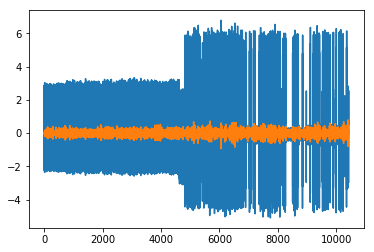

In [ ]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

Error before BA (mean / median): 2.47 / 2.66
Error after  BA (mean / median): 0.16 / 0.12


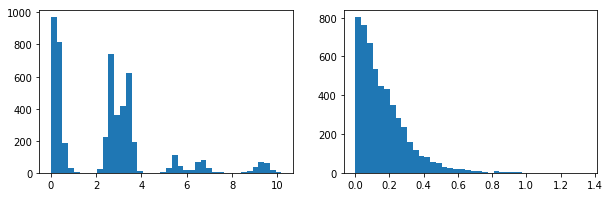

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40);
f[1].hist(ba_e, bins=40); 

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

In [ ]:
n_pts = newC.shape[1]
#p_ind = pts_ind[np.argmax(init_e)]
#p_ind = pts_ind[np.argmax(ba_e)] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(newC[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = newC[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'], cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    #f[cont].plot(*p_2d_proj_ba, "go")
    
print('\nECEF coordinates of the 3D point:', pts_3d_ba[p_ind])

lat, lon, h = ba_utils.ecef_to_latlon_custom(x=pts_3d_ba[p_ind,0], y=pts_3d_ba[p_ind,1], z=pts_3d_ba[p_ind,2])
print('lat, lon: [{:.3f}, {:.3f}], alt: {:.3f}'.format(lat, lon, h))

 ----> Real 2D loc in im 0  (sol) =  [364.42010498 719.13702393]
 ----> Proj 2D loc in im 0  before BA =  [359.9384058  723.79490149]
 ----> Proj 2D loc in im 0  after  BA =  [364.44157536 718.9986306 ]
              Reprojection error beofre BA: 9.139576741948872
              Reprojection error after  BA: 0.15986370845166675
 ----> Real 2D loc in im 1  (sol) =  [ 255.99711609 1029.56848145]
 ----> Proj 2D loc in im 1  before BA =  [ 258.16475306 1026.42972053]
 ----> Proj 2D loc in im 1  after  BA =  [ 255.92485057 1029.77900029]
              Reprojection error beofre BA: 5.306397892234088
              Reprojection error after  BA: 0.2827843657757114
 ----> Real 2D loc in im 2  (sol) =  [392.5435791  900.04528809]
 ----> Proj 2D loc in im 2  before BA =  [393.3479607  905.80181155]
 ----> Proj 2D loc in im 2  after  BA =  [392.61582325 899.91755468]
              Reprojection error beofre BA: 6.560905060740538
              Reprojection error after  BA: 0.19997755561843178

ECEF co

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [ ]:
lat, lon, alt = ba_utils.ecef_to_latlon_custom(pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2])

mymap = vistools.clickablemap(zoom=12)
## set the coordinates of the area of interest as a GeoJSON polygon
aoi = {'coordinates': [[[min(lon), min(lat)], [min(lon), max(lat)], 
                        [max(lon), max(lat)], [max(lon), min(lat)],
                        [min(lon), min(lat)]]], 'type': 'Polygon'}
# set the center of the aoi
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()
# display a polygon covering the aoi and center the map
mymap.add_GeoJSON(aoi) 
mymap.center = aoi['center'][::-1]
mymap.zoom = 15         
display(mymap)

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

In [ ]:
# set the index of the image to analyse
im_idx = 0

# pick all points visible in the selected image

pts_gt = newC[(im_idx*2):(im_idx*2+2),~np.isnan(newC[im_idx*2,:])].T
pts_3d_before = pts_3d[~np.isnan(newC[im_idx*2,:]),:]
pts_3d_after = pts_3d_ba[~np.isnan(newC[im_idx*2,:]),:]

# reprojections before bundle adjustment
proj = P_crop[im_idx] @ np.hstack((pts_3d_before, np.ones((pts_3d_before.shape[0],1)))).T
pts_reproj_before = (proj[:2,:]/proj[-1,:]).T

# reprojections after bundle adjustment
proj = P_crop_ba[im_idx] @ np.hstack((pts_3d_after, np.ones((pts_3d_after.shape[0],1)))).T
pts_reproj_after = (proj[:2,:]/proj[-1,:]).T

err_before = np.sum(abs(pts_reproj_before - pts_gt), axis=1)
err_after = np.sum(abs(pts_reproj_after - pts_gt), axis=1)

print('image {}, mean abs reproj error before BA: {:.4f}'.format(im_idx, np.mean(err_before)))
print('image {}, mean abs reproj error after  BA: {:.4f}'.format(im_idx, np.mean(err_after)))

# reprojection error histograms for the selected image
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Reprojection error before BA')
ax2.title.set_text('Reprojection error after  BA')
ax1.hist(err_before, bins=40); 
ax2.hist(err_after, bins=40);

plt.show()

Simple visualization. Green crosses represent the detected feature tracks, and red vectors are the distance to the reprojected point locations. 

In [ ]:
# warning: this is slow...

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Before BA')
ax2.title.set_text('After  BA')
ax1.imshow((mycrops[im_idx]['crop']), cmap="gray")
ax2.imshow((mycrops[im_idx]['crop']), cmap="gray")
for k in range(1000):
    # before bundle adjustment
    ax1.plot([pts_gt[k,0], pts_reproj_before[k,0] ], [pts_gt[k,1], pts_reproj_before[k,1]], 'r-')
    ax1.plot(*pts_gt[k], 'yx')
    # after bundle adjustment
    ax2.plot([pts_gt[k,0], pts_reproj_after[k,0] ], [pts_gt[k,1], pts_reproj_after[k,1]], 'r-')
    ax2.plot(*pts_gt[k], 'yx')
plt.show()


### Check the distance between the projection rays of two cameras

This gives an idea of the error in the traingulation of points before and after Bundle Adjustment.

In [ ]:
from PIL import Image

print('Checking the distance between projection rays...')

im1, im2 = 0,1

# get SIFT keypoints visible in both images
visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:])) 
pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]
tr_err, tr_err_ba = [],[]
pts_3d_sift, pts_3d_sift_ba = np.zeros((pts1.shape[1], 3)), np.zeros((pts1.shape[1], 3))

triangulate_err_hist = True 
triangulate_err_dsm  = False

# triangulate and compute triangulation error (i.e. distance between projection rays)
for n in range(pts1.shape[1]):
    pt1, pt2 = pts1[:,n].ravel(), pts2[:,n].ravel()
    # before bundle adjustment
    pts_3d_sift[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[im1], P_crop[im2])
    tr_err.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop[im1], P_crop[im2]))
    # after bundle adjustment
    pts_3d_sift_ba[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2])
    tr_err_ba.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2]))

if triangulate_err_hist:
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.title.set_text('Triangulation error before BA')
    ax2.title.set_text('Triangulation error after  BA')
    ax1.hist(tr_err, bins=40); 
    ax2.hist(tr_err_ba, bins=40);
    
# project dsm of the cloud but instead of projecting the height, project the triangulation error
if triangulate_err_dsm:
    # before bundle adjustment
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}.tif'.format(im1,im2))
    # after bundle adjustment
    x , y, z = pts_3d_sift_ba[:,0], pts_3d_sift_ba[:,1], pts_3d_sift_ba[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err_ba)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}_ba.tif'.format(im1,im2))
    
print('...done!\n')

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [ ]:
print('Writing point clouds of SIFT keypoints...')

if not os.path.isdir(input_dir+'/sift_clouds_before'):
    os.mkdir(input_dir+'/sift_clouds_before')
if not os.path.isdir(input_dir+'/sift_clouds_after'):
    os.mkdir(input_dir+'/sift_clouds_after')

'''
# pairs with extremly short baselines are not well posed for depth from stereo so we filter them
pairs_to_match = []
for i in range(n_cam):
    for j in range(i+1,n_cam):
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
        if np.linalg.norm(optical_center2 - optical_center1) > 150000 :
            pairs_to_match.append([i,j])  
'''    

max_east, min_east = - np.inf, np.inf
max_north, min_north = - np.inf, np.inf

for [im1,im2] in pairs_to_match:
        
    # get SIFT keypoints visible in both images
    visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:])) 
    pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]

    if len(pts1[0]) > 10:
        
        print(im1, im2)
        
        # triangulation of SIFT keypoints before bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop[im1], P_crop[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_before/{:02}_{:02}.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))

        # triangulation of SIFT keypoints after bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop_ba[im1], P_crop_ba[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_after/{:02}_{:02}_ba.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))
        
        if min(east) < min_east:
            min_east = min(east)
        if max(east) > max_east:
            max_east = max(east)
        if min(north) < min_north:
            min_north = min(north)
        if max(north) > max_north:
            max_north = max(north)

print('min_east:', min_east)
print('max_east:', max_east)
print('min_north:', min_north)
print('max_north:', max_north)

print('...done!\n')

### Recover the corrected RPCs from the corrected projection matrices

In [ ]:
#fit rpc

import rpc_fit
import copy

if not os.path.isdir(input_dir+'/rpc_adj'):
    os.mkdir(input_dir+'/rpc_adj')

# rpc fitting starts here
myrpcs_calib = []
verbose = True
for im_idx in range(n_cam):

    rpc_init = copy.copy(myrpcs2[im_idx])
    
    # calibrate and get error
    input_P, input_im, input_ecef = P_crop_ba[im_idx], mycrops[im_idx]['crop'], pts_3d_ba
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    rpc_calib.write_to_file(input_dir+'/rpc_adj/'+rpc_calib_fn)
    
    myrpcs_calib.append(rpc_calib)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

Verify that the reprojection of 3d points with the RPC is closer than 0.0001 to the reprojection given by the corrected projection matrix.

In [ ]:
# check that the calibrated RPCs are OK

for im_idx in range(int(newC.shape[0]/2)):
    for p_idx in range(newC.shape[1]):
        if not np.isnan(newC[2*im_idx,p_idx]):
            p_2d_gt = newC[(im_idx*2):(im_idx*2+2),p_idx]
            current_p = pts_3d_ba[p_idx,:]
            lat, lon, alt = ba_utils.ecef_to_latlon_custom(current_p[0], current_p[1], current_p[2])
            proj = P_crop[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row = myrpcs2[im_idx].projection(lon, lat, alt)
            p_2d_proj_rpc = np.hstack([col - mycrops[im_idx]['x0'], row - mycrops[im_idx]['y0']]).ravel()
            proj = P_crop_ba[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj_ba = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row = myrpcs_calib[im_idx].projection(lon, lat, alt)
            p_2d_proj_rpc_ba = np.hstack([col, row])

            reprojection_error_P = np.sum(abs(p_2d_proj_ba - p_2d_gt))
            reprojection_error_RPC = np.sum(abs(p_2d_proj_rpc_ba - p_2d_gt))

            if abs(reprojection_error_RPC - reprojection_error_P) > 0.001:
                print('cam {}, point {}'.format(im_idx, p_idx))
                print('GT            : {:.4f} , {:.4f}'.format(p_2d_gt[0], p_2d_gt[1]))
                print('RPC proj      : {:.4f} , {:.4f}'.format(p_2d_proj_rpc[0], p_2d_proj_rpc[1]))
                print('P proj        : {:.4f} , {:.4f}'.format(p_2d_proj[0], p_2d_proj[1]))
                print('P proj   (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_ba[0], p_2d_proj_ba[1]))
                print('RPC proj (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_rpc_ba[0], p_2d_proj_rpc_ba[1]))

    print('Finished checking image {}'.format(im_idx))

### Check baseline distances

In [ ]:
baseline_pairs, all_pairs_list = [], []
for i in range(n_img):
    for j in range(i+1,n_img):

        # check if the baseline between both cameras is large enough
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop_ba[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop_ba[j])
        baseline_pairs.append(np.linalg.norm(optical_center2 - optical_center1))
        all_pairs_list.append([i,j])

plt.plot(baseline_pairs)
plt.show()

In [ ]:
# check connectivity graph

#ba_utils.plot_connectivity_graph(newC, 10, save_pgf=False)

### Compare reprojection error using the L1A projection matrices or rpcs

In [ ]:
import rpc_fit
import copy

original_rpcs = [s2p.rpc_utils.rpc_from_geotiff(x) for x in myimages]

for im_idx in range(n_cam):

    rpc_init = copy.copy(original_rpcs[im_idx])


    h, w = mycrops[im_idx]['crop'].shape

    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            input_P = np.array(json.load(f)['P_projective'])

    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)


    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 0, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts_P, samples = p[idx_to_preserve], samples[idx_to_preserve]

    lat, lon, alt = ba_utils.ecef_to_latlon_custom(samples[:, 0], samples[:, 1], samples[:, 2])

    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)

    rows, cols = original_rpcs[im_idx].projection(lon, lat, alt) # ROWS Y COL ESTAN AL REVES ?
    proj_pts_RPC = np.vstack((rows, cols)).T
    
    print('im {} max diff {}'.format(im_idx, max(np.linalg.norm(proj_pts_P-proj_pts_RPC,axis=1))))

In [ ]:
plt.plot(np.linalg.norm(proj_pts_P-proj_pts_RPC, axis=1))

### Plot optical centers in 3D

In [ ]:
read_from_matrices = False
read_from_exterior_orientation = False

P_matrices = []
ocenters = []

if read_from_matrices:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            P_matrices.append(np.array(json.load(f)['P_projective']))
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_matrices[i])
            ocenters.append(optical_center1)    
elif read_from_exterior_orientation:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            tmp = json.load(f)['exterior_orientation']
            x_ecef, y_ecef, z_ecef = tmp['x_ecef_meters'], tmp['y_ecef_meters'], tmp['z_ecef_meters']
            ocenters.append(np.array([x_ecef, y_ecef, z_ecef]))
else: # read from rpcs approximation
    cam_model = 'Perspective'
    P_matrices = []
    for rpc2, crop, iter_cont in zip(myrpcs2, mycrops, np.arange(len(mycrops))):
        x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
        P_img = s2p.rpc_utils.approx_rpc_as_proj_matrix(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.alt_offset - 100, rpc2.alt_offset + 100, 10])
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_img/P_img[2,3])
        ocenters.append(optical_center1)
    
ocenters = np.array(ocenters)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot(ocenters[:,0], ocenters[:,1], ocenters[:,2], 'o')